In [1]:
import os
os.chdir('../')

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['random continuous']
sample_concept.prepare_data(env_steps, max_size=5000)
train_images = sample_concept.train_images
train_obs = sample_concept.train_obs

In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
layer = 4
print(f"Using model: {model_path} at layer: {layer}")

_, train_acts_dict = model(torch.tensor(train_obs), return_acts=True)
train_acts = train_acts_dict[layer].cpu().detach().numpy()
train_acts = train_acts.reshape(train_acts.shape[0], -1)

Using model: runs/20240128-235322/model_10000000.pt at layer: 4


In [5]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# Sort images by activation similarity to CAV
def sort(images, acts, cav, best_first=True):
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    #for i in range(4):
    #    print(round(cosine_similarity(acts[i], cav), 3))
    return images

def plot_images(images, n, save_name=None):
    fig, axes = plt.subplots(2, 2, figsize=(4, 4))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.tight_layout()
    if save_name:
        plt.savefig('figures/concept combinations/' + save_name, bbox_inches='tight')
    
    plt.show()
    
def sort_images(coefficients, best_first, name):
    train_images_sorted = sort(train_images, train_acts, coefficients, best_first)
    plot_images(train_images_sorted, 4, save_name=f'{name}_sorted.png')

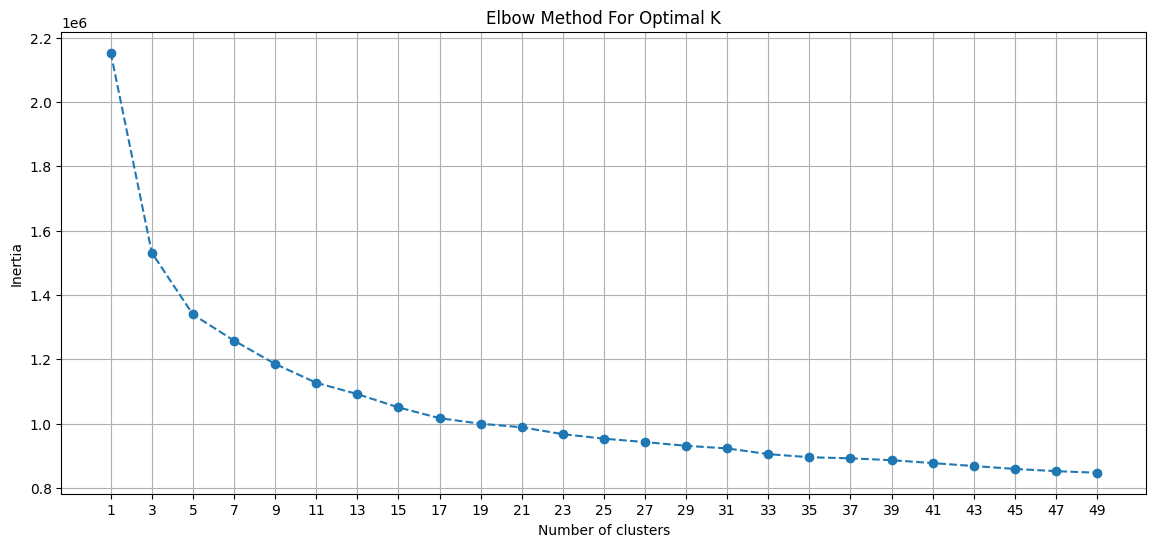

In [6]:
pca_N = 200
pca = PCA(n_components=pca_N)
activations_reduced = pca.fit_transform(train_acts)

# Determine the best number of clusters K
K_range = range(1, 51, 2)
inertia = []

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(activations_reduced)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(14, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

K = 10

In [7]:
# Apply K-means on the reduced data
kmeans_pca = KMeans(n_clusters=K, random_state=42)
kmeans_pca.fit(activations_reduced)

# Evaluate clusters
silhouette_avg_pca = silhouette_score(activations_reduced, kmeans_pca.labels_)
print(f"Silhouette Score after PCA: {silhouette_avg_pca}")

# Calculate information preserved and lost
information_preserved = pca.explained_variance_ratio_.sum()
information_lost = 1 - information_preserved

print(f"Information preserved after PCA: {information_preserved * 100:.2f}%")

# Cluster data in reduced space
kmeans_pca = KMeans(n_clusters=K, random_state=42).fit(activations_reduced)

# Inverse-transform data points for each cluster and calculate new centroids
centroids_original = np.zeros((K, train_acts.shape[1]))
for i in range(K):
    # Identify data points in this cluster
    cluster_indices = np.where(kmeans_pca.labels_ == i)[0]
    cluster_points_reduced = activations_reduced[cluster_indices]
    print(f"Cluster {i} size: {cluster_points_reduced.shape[0]}")
    
    # Inverse-transform these points to the original space
    cluster_points_original = pca.inverse_transform(cluster_points_reduced)
    
    # Calculate the centroid of these points in the original space
    centroids_original[i, :] = np.mean(cluster_points_original, axis=0)

Silhouette Score after PCA: 0.15915197134017944
Information preserved after PCA: 94.54%
Cluster 0 size: 280
Cluster 1 size: 479
Cluster 2 size: 252
Cluster 3 size: 1042
Cluster 4 size: 250
Cluster 5 size: 461
Cluster 6 size: 216
Cluster 7 size: 169
Cluster 8 size: 311
Cluster 9 size: 540


In [8]:
concept_cavs = {}
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if score > 0.8:
        cav = probe[1].weight.data.cpu().numpy().squeeze()
        concept_cavs[concept.name] = cav
    print(f"{concept.name:^35} | {score:^10.4f}")

            player low              |   0.9890  
            difficulty              |   0.8440  
           player in air            |   0.9780  
       player dodging in air        |   0.9620  
       player fall velocity         |   0.8120  
      player standing on wall       |   0.9690  
      player dodging on wall        |   0.8330  
          events quantity           |   0.7670  
           visible wall             |   0.9210  
          visible bullet            |   0.8890  
           visible lava             |   0.9570  
           coin quantity            |   0.6890  
        good visible events         |   0.7200  
        bad visible events          |   0.8300  
         two close bullets          |   0.8500  
           bullet close             |   0.7630  
    bullet aligned with player      |   0.7640  
          player dodging            |   0.9510  
          coin above lava           |   0.6400  
         lava below player          |   0.9320  
        bullet below

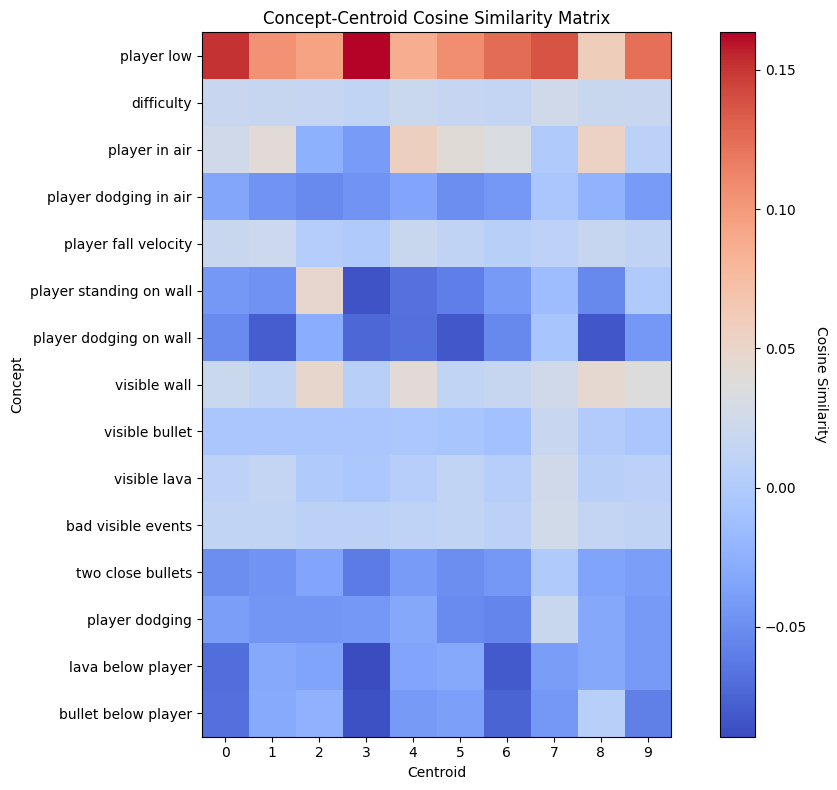

In [9]:
num_concepts = len(concept_cavs)
num_centroids = centroids_original.shape[0]

# New similarity matrix dimensions: num_concepts x num_centroids
similarity_matrix = np.zeros((num_concepts, num_centroids))

# Populate the matrix
concept_names = list(concept_cavs.keys())
centroid_names = [str(i) for i in range(num_centroids)]

for i, concept in enumerate(concept_names):
    for j in range(num_centroids):
        similarity_matrix[i, j] = cosine_similarity(concept_cavs[concept], centroids_original[j])

# Plotting the updated similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
plt.xlabel('Centroid')
plt.ylabel('Concept')
cbar = plt.colorbar()
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15)
plt.title('Concept-Centroid Cosine Similarity Matrix')
plt.xticks(np.arange(num_centroids), centroid_names)
plt.yticks(np.arange(num_concepts), concept_names)
plt.tight_layout()
plt.savefig('figures/concept_centroid_similarity.png', dpi=300)
plt.show()

Cluster 0 mean silhouette score: 0.045853596180677414


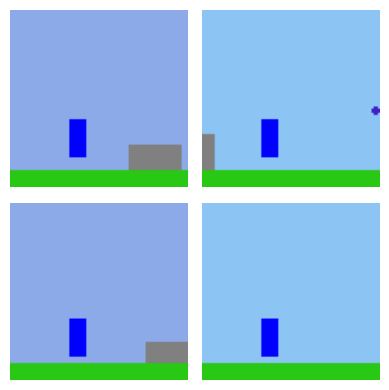

Cluster 1 mean silhouette score: 0.11638114601373672


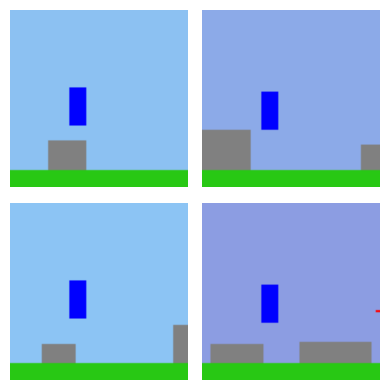

Cluster 2 mean silhouette score: 0.0875622034072876


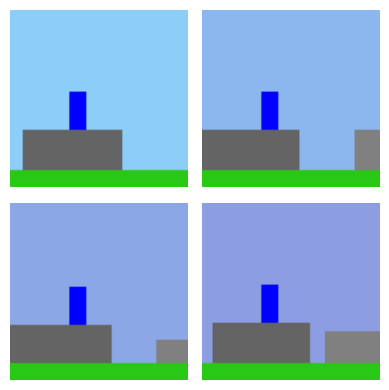

Cluster 3 mean silhouette score: 0.28783348202705383


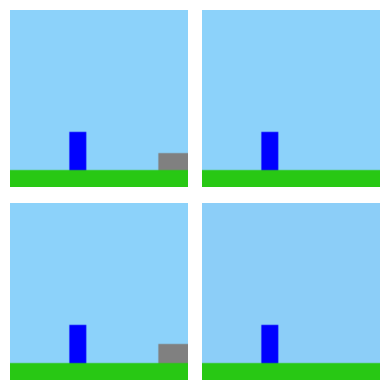

Cluster 4 mean silhouette score: 0.06410150974988937


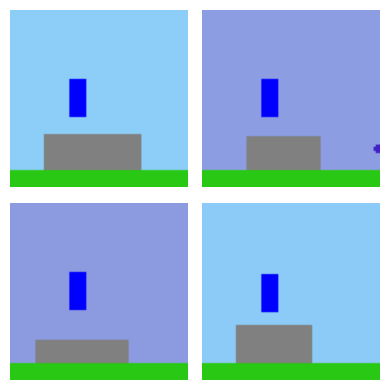

Cluster 5 mean silhouette score: 0.10455481708049774


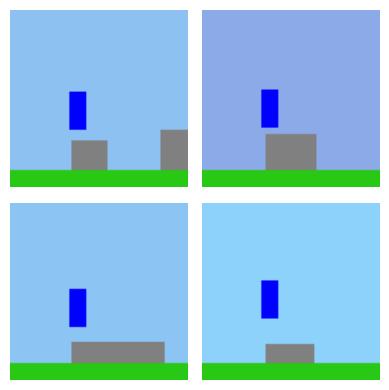

Cluster 6 mean silhouette score: 0.27572399377822876


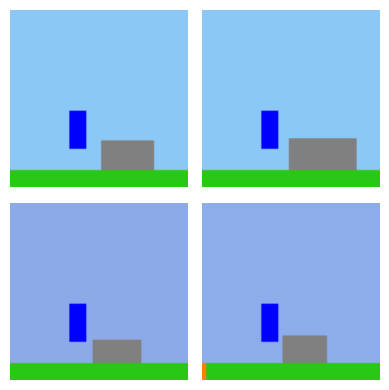

Cluster 7 mean silhouette score: -0.04775882512331009


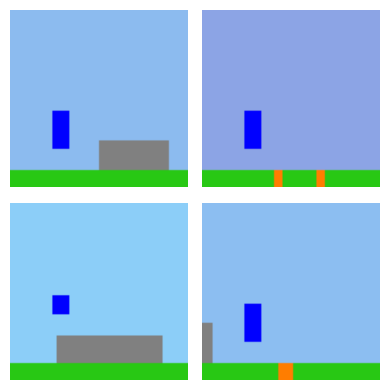

Cluster 8 mean silhouette score: 0.139214426279068


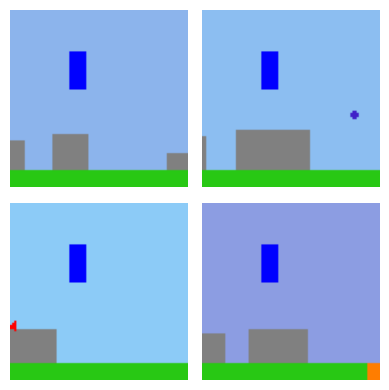

Cluster 9 mean silhouette score: 0.06014132872223854


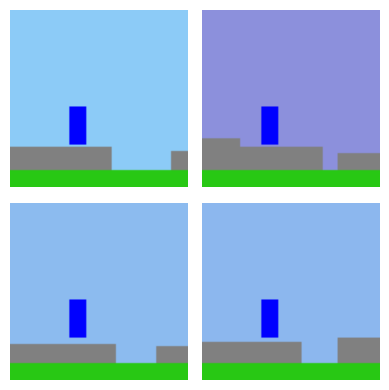

In [10]:
cluster_labels = kmeans_pca.labels_
silhouette_vals = silhouette_samples(train_acts, cluster_labels)

for i in range(K):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    mean_silhouette = np.mean(cluster_silhouette_vals)
    print(f"Cluster {i} mean silhouette score: {mean_silhouette}")
    sort_images(centroids_original[i], best_first=True, name=f'cluster_{K}')